In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Step-1 Reading CSV data

In [3]:
data = pd.read_csv('forestfires.csv')
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Step-2 Explaining Attributes


   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

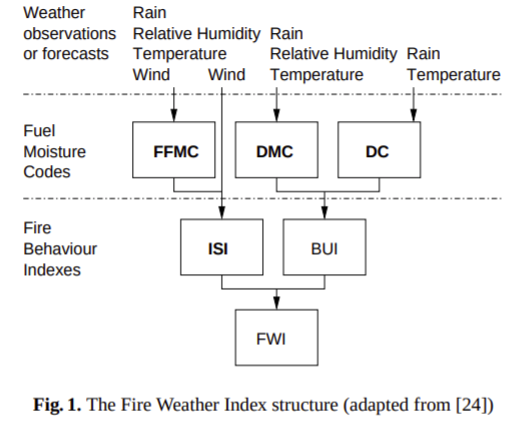

### Step-3 Data Columns
* The below attributes are used for regression task.
* shape of the data frame is shown it contains 517 recorded examples.

In [4]:
print(data.columns)
print(data.shape)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')
(517, 13)


### Step-4 Checking for NULL values for each column

In [5]:
print(list(data.isnull().any()))

[False, False, False, False, False, False, False, False, False, False, False, False, False]


### Step-5 Describing the data
Showing statistics summary(count, mean,std,min and all the quartileve values) for each numerical attribute

In [10]:
data.copy(deep=True).drop(['month','day'],axis=1).describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Plotting the frequency plot of target variable (area).
From the frequency plot we can see that target variable is highly rightly skewed. Hence instead of prediction on linear scale(see left fig) we can convert the area to log scale to remove right skewedness.

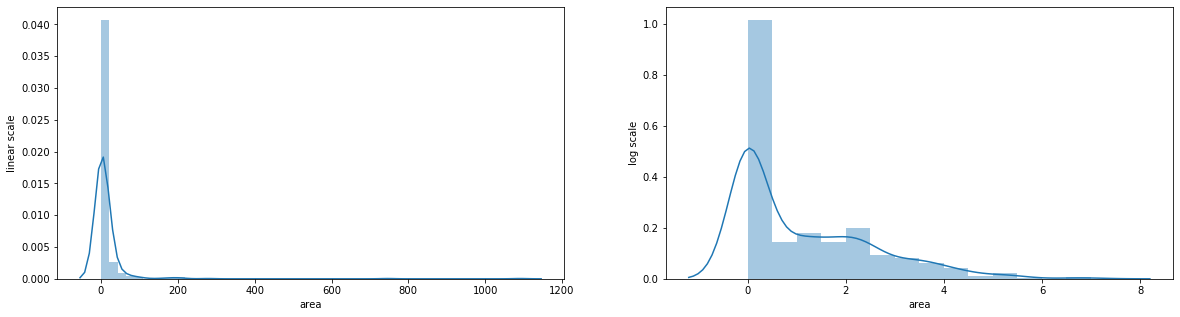

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20, 5))
_=sb.distplot(data[['area']],ax=ax1)
_=sb.distplot(np.log(data[['area']]+1),ax=ax2)
_=ax1.set_xlabel('area')
_=ax2.set_xlabel('area')
_=ax1.set_ylabel('linear scale')
_=ax2.set_ylabel('log scale')

### Plotting the distribution of each attributes.
The  histogram visualizes univariate distribution. This can be usefull for checking summary statistics(mean,median,range,std dev) of each numerical variable. Alternatively we can visualize this with violin plot or box plot

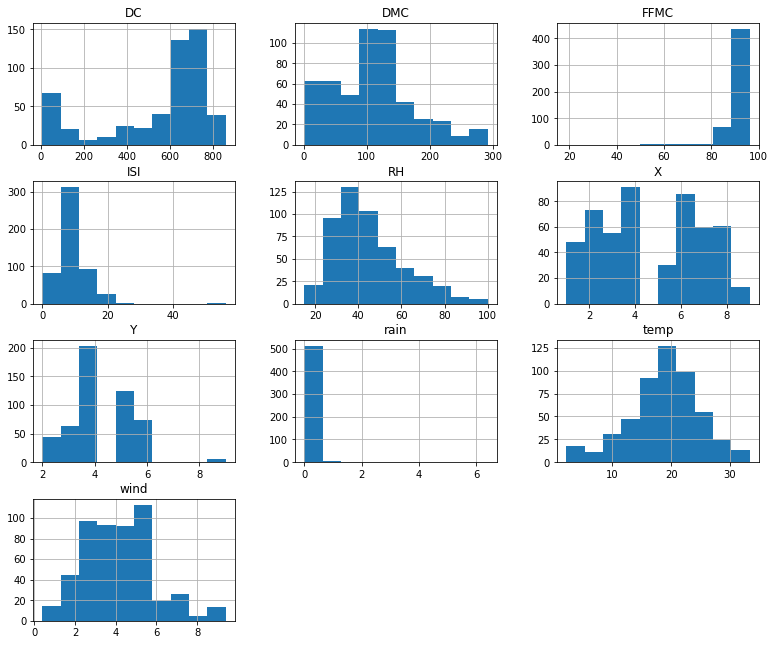

In [24]:
col =['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain']
train= data[col]
_=train.hist(figsize=(13, 11))

### Correlation Analysis of variables
The correlation heatmap shows correlation between a variable X (X-axis variable) and Y (Y-axis variable). Two variable are correlated if correlation heatmap shows lighter color. For ex. variable FFMC and ISI have correlation coffecient of 0.53 (positively correlated) and variable RH and temp have correlation coffecient of -0.53 (negatively correlated)

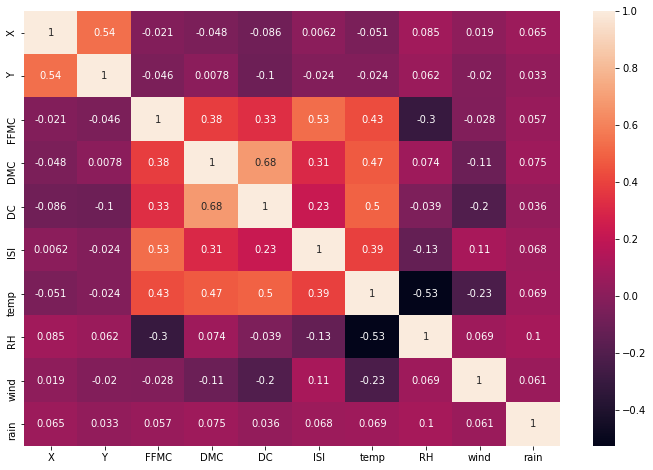

In [16]:
plt.figure(figsize=(12, 8))
corr = train.corr()
sb.heatmap(corr, annot=True)
plt.show()

### Step-6 Label encoding month and dates 
Month and Day attributes are categorical variables hence we can perform label encoding ( 1-of-C Encoding ) using sklearn labelencoder function.

In [17]:
le = LabelEncoder()
data['month']=le.fit_transform(data['month'])
le = LabelEncoder()
data['day']=le.fit_transform(data['day'])

### Converting target variable (area) to log-scale to remove right skewedness in regression prediction

In [20]:
data['area'] = np.log(data['area']+1)

### Step-7 Training the Support Vector Regressor using all the features
The distribution plot of all the predictor variables shows that predictor variables are of different scales hence we first perform standard scaling for each attribition.
* Step-1 The formula for standard scale of attribute $x$ is $\bar{x}= \frac{x-\mu}{\sigma}$
* Step-2 Initialize the SVR model with RBF kernel
* Step-3 Performing K-Fold cross validation with n_splits=10
* Step-4 Appending all the scores (RMSE) in score array

In [21]:
ss = StandardScaler()
ss.fit_transform(data.iloc[:,:len(col)])
X = data.iloc[:,:len(col)]
y = data.iloc[:,len(col)]
scores = []
best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(mean_squared_error(best_svr.predict(X_test),y_test))

### Step-8  Average Score
Calculation average RMSE score of the model for 10 splits

In [198]:
print('average rmse={}'.format(np.mean(scores)))

average rmse=0.015605847315347634


### Conclusion

Forest fires cause a significant environmental damage while threatening human lives. We used a Data Mining (DM) approach that uses meteorological data, as detected by local sensors in weather stations. The meteorological data can be collected in real-time and with very low cost and is known to influence forest fires. 
This problem was modeled computationally as a regression task, where the aim was the prediction of the burned area. The DM algorithm Support Vector Regression (SVR) Machines is used for the regression task. Upon cross validation we can show the validation error of SVR is 0.015 which shows satisfactory performance.

### Future Work

We can try some feature selection mechanisms and train the SVR model on different feature attributes
We can try DT based model as it is more robust to outliers
The current algorithm is offline algorithm where we are learning the model from current data. We can explore some on-line ML algorithms which 
performs better in continutous learning scenario.